# FIGURE AND MAPS

In [156]:
# note that the order of points in GeoPandas is longitude, latitude 
# (opposite order from that of many data sets)

import geopandas
import shapely.geometry
import shapely.ops
import pyproj
import pandas

import time
import numpy

import pygsheets
import cartopy
import matplotlib.pyplot as mp
import matplotlib

In [157]:
# set open sans as default font
mp.rcParams['font.family'] = 'Open Sans'

# gemplot variables

In [158]:
footer_color = "#222222"
footer_lineheight = 1.2
footer_fontsize = 14

# default height of a figure is 450 pixels

# gemstyle does this:
# specify a base_ratio, then set base_size = base_ratio*16
# 1. add 6 line margin all the way around
# 2. color of title is "#222222", margin 6666, size=base_size*1.5, lineheight=1.35, bold font
# 3. color of subtitle is "#333333", margin 0666, padding top=12, bottom=12, size=base_size*1.15, lineheight=1.45
# 4. set caption info as linehight=1.2, size=base_size*0.875, color="#222222", margin=18,6,6,6

base_ratio = 1.0
base_size = base_ratio * 16
color_title = "#222222"
color_subtitle = "#333333"
color_grid = "#cbcbcb"

text_weight_normal = 400
text_weight_bold = 700

# save fig
#' @keywords save_gem_plot
#' @examples
#' save_gem_plot(
#' plot_grid = line_plot_with_gem_footer,
#' save_filepath = "filename_that_my_plot_should_be_saved_to-nc.png",
#' width_pixels = 770,
#' height_pixels = 540,
#' resolution = 4
#' )
#'
#' @export
# save plot function - now separated from finalise_plot function and setting the resolution as part of the arguments
# save_gem_plot <- function (plot_grid, save_filepath, width_pixels = 640, height_pixels = 450, resolution = 3) {
#   grid::grid.draw(plot_grid)

#   #save it
#   ggplot2::ggsave(plot=plot_grid,
#                   width= (width_pixels/72),
#                   height= (height_pixels/72),
#                   dpi = resolution * 100,
#                   filename = save_filepath,
#                   bg="white")
# }

#width_pixels = 640 # default
#height_pixels = 450 # default

# map color variables

In [260]:
construction_color = matplotlib.colormaps['Reds'](0.75)
proposed_color = matplotlib.colormaps['Oranges'](0.25)
#operating_color = '#c2c2c2'
other_land_color = '#ffffff'
other_land_alpha = 1
highlight_land_color = '#c2c2c2'
highlight_land_alpha = 0.2
water_color = '#a1bccc'
water_alpha = 0.3
operating_color = '0.25'
operating_terms_color = '0.666'
construction_lw = 1.
operating_lw = 0.25
ehb_alpha = 1.

# import states/provinces shapefile

In [160]:
ne_states_provinces = '/Users/baird/Dropbox/_gis-data/_natural_earth_data/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp'
ne_states_provinces_gdf = geopandas.read_file(ne_states_provinces)

# import countries shapefile

In [161]:
countries_gdf = geopandas.read_file('/Users/baird/Dropbox/_gis-data/_natural_earth_data/ne_50m_admin_0_countries_lakes/ne_50m_admin_0_countries_lakes.shp')

# import lakes shapefile

In [162]:
lakes_gdf = geopandas.read_file('/Users/baird/Dropbox/_gis-data/_natural_earth_data/ne_10m_lakes/ne_10m_lakes.shp')
oceans_gdf = geopandas.read_file('/Users/baird/Dropbox/_gis-data/_natural_earth_data/ne_10m_ocean/ne_10m_ocean.shp')

# import pipelines and terminals

In [253]:
pipes_gdf = geopandas.read_file('GEM-Gas-and-Hydrogen-Pipelines-2024-02-13.geojson')
terms_gdf = geopandas.read_file('GEM-GGIT-LNG-Terminals-2024-02-12.geojson')

# import pipelines data (country lists etc.)

In [227]:
gc = pygsheets.authorize(service_account_env_var='GDRIVE_API_CREDENTIALS')

spreadsheet = gc.open_by_key('1foPLE6K-uqFlaYgLPAUxzeXfDO5wOOqE7tibNHeqTek')
#spreadsheet = gc.open_by_key('1PKsCoVnfnCEalDBOF0Fmny0-pg1qy86DoReNHI-97WM') # version from 6 March 2023 for EGT report

region_df_orig = spreadsheet.worksheet('title', 'Country dictionary').get_as_df(start='A2')

gas_pipes = spreadsheet.worksheet('title', 'Gas pipelines').get_as_df(start='A3')
# oil_pipes = spreadsheet.worksheet('title', 'Oil/NGL pipelines').get_as_df(start='A3')

gas_pipes = gas_pipes.drop('WKTFormat', axis=1) # delete WKTFormat column
# oil_pipes = oil_pipes.drop('WKTFormat', axis=1)
pipes_df_orig = gas_pipes.copy()

# # remove empty cells for pipes, owners
pipes_df_orig = pipes_df_orig.loc[pipes_df_orig.PipelineName!='']
#pipes_df_orig = pipes_df_orig.loc[pipes_df_orig.Wiki!='']
pipes_df_orig = pipes_df_orig.loc[pipes_df_orig.Fuel.isin(['Gas','Hydrogen'])]

# #get other relevant sheets
country_ratios_df = spreadsheet.worksheet('title', 'Country ratios by pipeline').get_as_df()

# parents_df = spreadsheet.worksheet('title', 'Parent metadata (3/3)').get_as_df(start='A2')
# parents_df = parents_df.loc[parents_df.Parent!='']
# parents_df.set_index('Parent', inplace=True)

In [228]:
country_ratios_df.replace('--', numpy.nan, inplace=True)
pipes_df_orig.replace('--',numpy.nan,inplace=True)
pipes_df_orig['ProposalYear'] = pipes_df_orig['ProposalYear'].replace('',numpy.nan)

In [229]:
# region_df_eu = region_df_orig.copy()[region_df_orig['EuropeanUnion']=='Yes']
region_df_egt = region_df_orig.loc[region_df_orig.EuroGasTracker=='Yes']
# region_df_europe = region_df_orig.copy()[region_df_orig['Region']=='Europe']
# region_df_eu_uk = region_df_orig.copy()[(region_df_orig['Region']=='Europe') | 
#                                           (region_df_orig['Country'].isin(['United Kingdom','Israel']))]

In [230]:
region_df_touse = region_df_egt.copy()

In [236]:
europe_projectids = country_ratios_df.loc[
        (country_ratios_df.Country.isin(region_df_touse.Country.tolist()))].ProjectID.unique().tolist()

pci6_projectids = pipes_df_orig.loc[pipes_df_orig.PCI6=='yes'].ProjectID.tolist()

# Figure 1 - terminals and pipelines in Europe

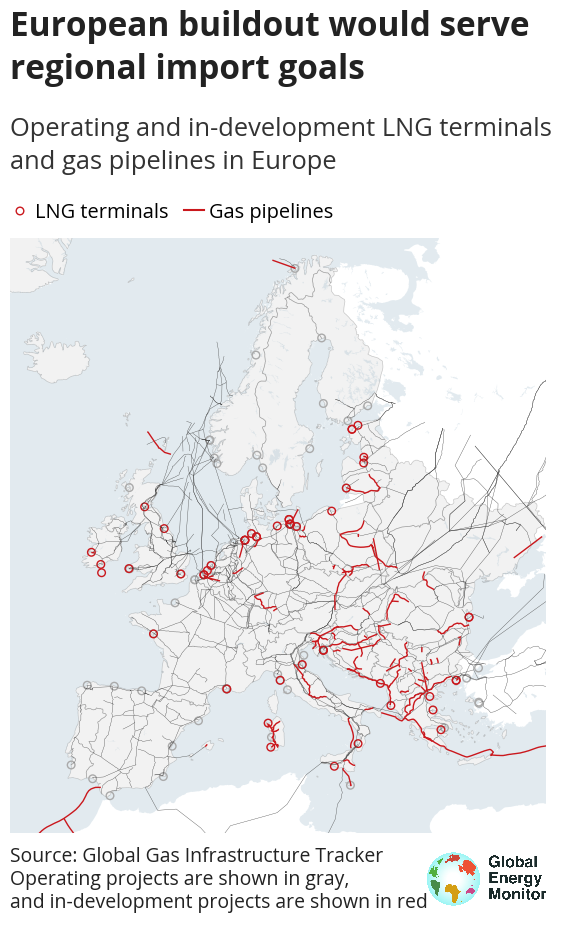

In [232]:
map_proj = cartopy.crs.LambertConformal(central_longitude=0, 
                             central_latitude=52, 
                             false_easting=0.0, 
                             false_northing=-20.0, 
                             standard_parallels=[35.0,65.0], 
                             globe=None)

#map_proj = cartopy.crs.PlateCarree()
data_proj = cartopy.crs.PlateCarree()

width_pixels = 640 # 640 default
height_pixels = 450 # 450 default
fig = mp.figure(figsize=(width_pixels/72, height_pixels/72))
fig.canvas.draw()

ax = fig.add_subplot(111, projection=map_proj)
ax.set_extent([-13,30,33,72], crs=data_proj)

other_land = ax.add_geometries(countries_gdf.loc[~countries_gdf.SOVEREIGNT.isin(region_df_touse.Country.tolist()+['Czechia','Republic of Serbia','Macedonia'])]['geometry'], 
                               facecolor=other_land_color, 
                               edgecolor='None', 
                               crs=data_proj, 
                               alpha=other_land_alpha)

highlight_land = ax.add_geometries(countries_gdf.loc[countries_gdf.SOVEREIGNT.isin(region_df_touse.Country.tolist()+['Czechia','Republic of Serbia','Macedonia'])]['geometry'], 
                                   facecolor=highlight_land_color, 
                                   edgecolor='0', 
                                   linewidth=0.5,
                                   crs=data_proj, 
                                   alpha=highlight_land_alpha)

lakes = ax.add_geometries(lakes_gdf['geometry'], 
                          facecolor=water_color, 
                          edgecolor='None', 
                          crs=data_proj, 
                          alpha=water_alpha)

oceans = ax.add_geometries(oceans_gdf['geometry'], 
                           facecolor=water_color, 
                           edgecolor='None', 
                           crs=data_proj, 
                           alpha=water_alpha)

# PIPELINES
ax.add_geometries(pipes_gdf.loc[
                  (pipes_gdf.Status.isin(['Operating']))&
                  (pipes_gdf.Fuel=='Gas')&
                  (pipes_gdf.ProjectID.isin(europe_projectids))]['geometry'], 
                  crs=data_proj, 
                  facecolor='None', 
                  edgecolor=operating_color, 
                  linewidth=operating_lw, zorder=5)

ax.add_geometries(pipes_gdf.loc[
                  (pipes_gdf.Status.isin(['Proposed', 'Construction']))&
                  (pipes_gdf.Fuel=='Gas')&
                  (pipes_gdf.ProjectID.isin(europe_projectids))]['geometry'], 
                  crs=data_proj, 
                  facecolor='None', 
                  edgecolor=construction_color,
                  linewidth=construction_lw, zorder=5)

# # TERMINALS
points_list = terms_gdf.loc[(terms_gdf.Status.isin(['Operating']))&
                            (terms_gdf.Country.isin(region_df_touse.Country.tolist()))]['geometry'].tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=operating_terms_color, 
           linewidth=1,
           zorder=3, marker='o',
           s=30)

points_list = terms_gdf.loc[(terms_gdf.Status.isin(['Proposed','Construction']))&
                            (terms_gdf.Country.isin(region_df_touse.Country.tolist()))]['geometry'].tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=construction_color, 
           linewidth=1,
           zorder=3, marker='o',
           s=30, label='LNG terminals')

fig.tight_layout()

# turn off outline
#ax.outline_patch.set_visible(False)
ax.axis('off')

# add titles, first get the location of the yaxis labels so they can line up exactly
# call it "x_location"
bbox = ax.get_tightbbox(renderer=fig.canvas.renderer)
x_location,y_location = ax.transAxes.inverted().transform([bbox.x0, bbox.y1])
handles,labels = ax.get_legend_handles_labels()

pipeline_indev_handle = matplotlib.patches.Patch(color=construction_color)
pipeline_indev_handle = matplotlib.lines.Line2D([0], [0], color=construction_color)
pipeline_indev_label = 'Gas pipelines'

legend = ax.legend(
          handles=handles+[pipeline_indev_handle],
          labels=labels+[pipeline_indev_label],
          fontsize=base_size*0.9,
          frameon=False,
          loc='lower left',
          bbox_to_anchor=(x_location,1.025),
          bbox_transform=ax.transAxes,
          handlelength=1,
          handleheight=1,
          ncols=4,
          borderpad=0,
          borderaxespad=0,
          columnspacing=0.75,
          handletextpad=0.25)

# now get tight bbox again for further placement AFTER legend is added
bbox = legend.get_tightbbox(renderer=fig.canvas.renderer)
x_location,y_location = ax.transAxes.inverted().transform([bbox.x0, bbox.y1])
ax.text(s='Operating and in-development LNG terminals\nand gas pipelines in Europe',
        size=base_size*1.15,
        color=color_subtitle,
        x=x_location,
        y=y_location+0.045,
        ha='left',
        va='bottom',
        weight=text_weight_normal,
        transform=ax.transAxes,
        linespacing=1.45,
        wrap=False)

bbox_with_subtitle = ax.get_tightbbox(renderer=fig.canvas.renderer)
x_location_subtitle,y_location_subtitle = ax.transAxes.inverted().transform([bbox_with_subtitle.x0, bbox_with_subtitle.y1])
ax.text(s='European buildout would serve\nregional import goals',
        size=base_size*1.5,
        color=color_title,
        x=x_location,
        y=y_location_subtitle+0.05,#1.2,
        ha='left',
        va='bottom',
        weight=text_weight_bold,
        transform=ax.transAxes,
        linespacing=1.35,
        wrap=False)

# GEM LOGO AND NOTES
gem_logo = matplotlib.image.imread('/Users/baird/Dropbox/_git_ALL/_github-repos-gem/gemplot-python/data/gem_logo_padding.png')
logo_image_box = matplotlib.offsetbox.OffsetImage(gem_logo, zoom=0.035)
logo_annotation_box = matplotlib.offsetbox.AnnotationBbox(logo_image_box,
                                                          (1,0), # sets box alignment to lower right corder
                                                          xycoords='axes fraction',
                                                          box_alignment=(1.,1.25), 
                                                          frameon=False)
ax.add_artist(logo_annotation_box)

# note at bottom
ax.text(s='Source: Global Gas Infrastructure Tracker\nOperating projects are shown in gray,\nand in-development projects are shown in red',
        size=base_size*0.875,
        color=color_title,
        x=x_location,
        y=-0.08*450/height_pixels,
        ha='left',
        va='center',
        weight=text_weight_normal,
        transform=ax.transAxes,
        linespacing=1.2,
        wrap=False)

fig.savefig('./figures/Figure01-pipelines-and-terminals.png', 
            dpi=300,
            bbox_inches='tight',
            transparent=False)

fig.savefig('./figures/Figure01-pipelines-and-terminals.pdf', 
            bbox_inches='tight',
            transparent=False)

# Figure 6 - hydrogen map

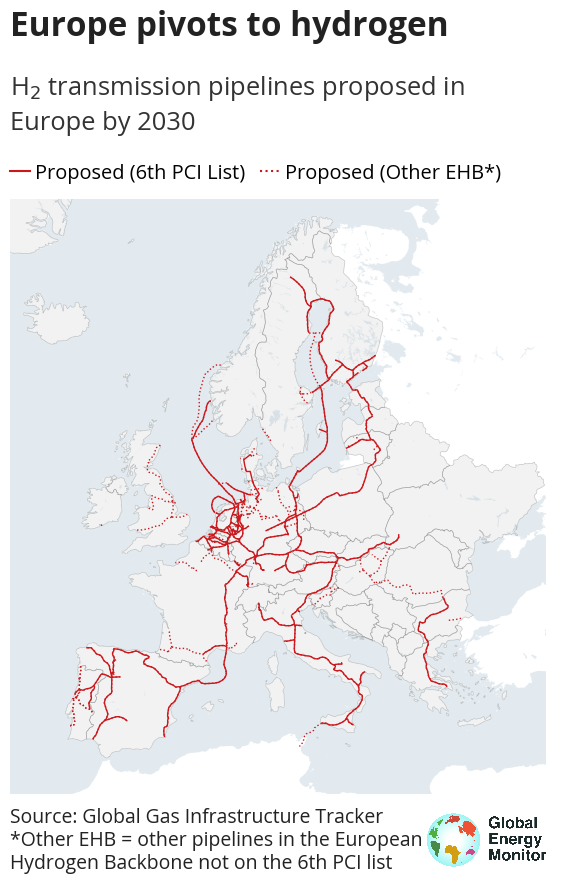

In [262]:
map_proj = cartopy.crs.LambertConformal(central_longitude=0, 
                             central_latitude=52, 
                             false_easting=0.0, 
                             false_northing=-20.0, 
                             standard_parallels=[35.0,65.0], 
                             globe=None)

data_proj = cartopy.crs.PlateCarree()

width_pixels = 640 # 640 default
height_pixels = 450 # 450 default
fig = mp.figure(figsize=(width_pixels/72, height_pixels/72))
fig.canvas.draw()

ax = fig.add_subplot(111, projection=map_proj)
ax.set_extent([-13,30,33,72], crs=data_proj)

other_land = ax.add_geometries(countries_gdf.loc[~countries_gdf.SOVEREIGNT.isin(region_df_touse.Country.tolist()+['Czechia','Republic of Serbia','Macedonia'])]['geometry'], 
                               facecolor=other_land_color, 
                               edgecolor='None', 
                               crs=data_proj, 
                               alpha=other_land_alpha)

highlight_land = ax.add_geometries(countries_gdf.loc[countries_gdf.SOVEREIGNT.isin(region_df_touse.Country.tolist()+['Czechia','Republic of Serbia','Macedonia'])]['geometry'], 
                                   facecolor=highlight_land_color, 
                                   edgecolor='0', 
                                   linewidth=0.5,
                                   crs=data_proj, 
                                   alpha=highlight_land_alpha)

lakes = ax.add_geometries(lakes_gdf['geometry'], 
                          facecolor=water_color, 
                          edgecolor='None', 
                          crs=data_proj, 
                          alpha=water_alpha)

oceans = ax.add_geometries(oceans_gdf['geometry'], 
                           facecolor=water_color, 
                           edgecolor='None', 
                           crs=data_proj, 
                           alpha=water_alpha)

# PIPELINES
ax.add_geometries(pipes_gdf.loc[(pipes_gdf.Status.isin(['Proposed','Construction']))&
                  (pipes_gdf.Fuel=='Hydrogen')&
                  (~pipes_gdf.ProjectID.isin(pci6_projectids))
                  ].geometry, 
                  crs=data_proj, 
                  facecolor='None', 
                  edgecolor=construction_color,
                  linestyle=':',
                  linewidth=construction_lw,
                  zorder=5, 
                  alpha=ehb_alpha)

ax.add_geometries(pipes_gdf.loc[(pipes_gdf.Status.isin(['Proposed','Construction']))&
                  (pipes_gdf.Fuel=='Hydrogen')&
                  (pipes_gdf.ProjectID.isin(pci6_projectids))
                  ].geometry, 
                  crs=data_proj, 
                  facecolor='None', 
                  edgecolor=construction_color,
                  linewidth=construction_lw, zorder=5)

fig.tight_layout()

ax.axis('off')

# add titles, first get the location of the yaxis labels so they can line up exactly
# call it "x_location"
bbox = ax.get_tightbbox(renderer=fig.canvas.renderer)
x_location,y_location = ax.transAxes.inverted().transform([bbox.x0, bbox.y1])
handles,labels = ax.get_legend_handles_labels()

all_ehb_handle = matplotlib.lines.Line2D([0], [0], color=construction_color, ls=':', alpha=ehb_alpha)
all_ehb_label = 'Proposed (Other EHB*)'

pci6_handle = matplotlib.lines.Line2D([0], [0], color=construction_color)
pci6_label = 'Proposed (6th PCI List)'

legend = ax.legend(
          handles=[pci6_handle,all_ehb_handle],
          labels=[pci6_label,all_ehb_label],
          fontsize=base_size*0.9,
          frameon=False,
          loc='lower left',
          bbox_to_anchor=(x_location,1.025),
          bbox_transform=ax.transAxes,
          handlelength=1,
          handleheight=1,
          ncols=4,
          borderpad=0,
          borderaxespad=0,
          columnspacing=0.75,
          handletextpad=0.25)

# now get tight bbox again for further placement AFTER legend is added
bbox = legend.get_tightbbox(renderer=fig.canvas.renderer)
x_location,y_location = ax.transAxes.inverted().transform([bbox.x0, bbox.y1])
ax.text(s='H$_2$ transmission pipelines proposed in\nEurope by 2030',
        size=base_size*1.15,
        color=color_subtitle,
        x=x_location,
        y=y_location+0.045,
        ha='left',
        va='bottom',
        weight=text_weight_normal,
        transform=ax.transAxes,
        linespacing=1.45,
        wrap=False)

bbox_with_subtitle = ax.get_tightbbox(renderer=fig.canvas.renderer)
x_location_subtitle,y_location_subtitle = ax.transAxes.inverted().transform([bbox_with_subtitle.x0, bbox_with_subtitle.y1])
ax.text(s='Europe pivots to hydrogen',
        size=base_size*1.5,
        color=color_title,
        x=x_location,
        y=y_location_subtitle+0.05,#1.2,
        ha='left',
        va='bottom',
        weight=text_weight_bold,
        transform=ax.transAxes,
        linespacing=1.35,
        wrap=False)

# GEM LOGO AND NOTES
gem_logo = matplotlib.image.imread('/Users/baird/Dropbox/_git_ALL/_github-repos-gem/gemplot-python/data/gem_logo_padding.png')
logo_image_box = matplotlib.offsetbox.OffsetImage(gem_logo, zoom=0.035)
logo_annotation_box = matplotlib.offsetbox.AnnotationBbox(logo_image_box,
                                                          (1,0), # sets box alignment to lower right corder
                                                          xycoords='axes fraction',
                                                          box_alignment=(1.,1.25), 
                                                          frameon=False)
ax.add_artist(logo_annotation_box)

# note at bottom
ax.text(s='Source: Global Gas Infrastructure Tracker\n*Other EHB = other pipelines in the European\nHydrogen Backbone not on the 6th PCI list',
        size=base_size*0.875,
        color=color_title,
        x=x_location,
        y=-0.08*450/height_pixels,
        ha='left',
        va='center',
        weight=text_weight_normal,
        transform=ax.transAxes,
        linespacing=1.2,
        wrap=False)

fig.savefig('./figures/Figure06-hydrogen.png', 
            dpi=300,
            bbox_inches='tight',
            transparent=False)

fig.savefig('./figures/Figure06-hydrogen.pdf', 
            bbox_inches='tight',
            transparent=False)

# import pipelines dataset

In [165]:
gc = pygsheets.authorize(service_account_env_var='GDRIVE_API_CREDENTIALS')

spreadsheet = gc.open_by_key('1foPLE6K-uqFlaYgLPAUxzeXfDO5wOOqE7tibNHeqTek')
#spreadsheet = gc.open_by_key('1PKsCoVnfnCEalDBOF0Fmny0-pg1qy86DoReNHI-97WM') # version from 6 March 2023 for EGT report

gas_pipes = spreadsheet.worksheet('title', 'Gas pipelines').get_as_df(start='A3')
oil_pipes = spreadsheet.worksheet('title', 'Oil/NGL pipelines').get_as_df(start='A3')

gas_pipes = gas_pipes.drop('WKTFormat', axis=1) # delete WKTFormat column
oil_pipes = oil_pipes.drop('WKTFormat', axis=1)
pipes_df_orig = gas_pipes.copy()

# remove empty cells for pipes, owners
pipes_df_orig = pipes_df_orig.loc[pipes_df_orig.PipelineName!='']
pipes_df_orig = pipes_df_orig.loc[pipes_df_orig.Wiki!='']
pipes_df_orig = pipes_df_orig.loc[pipes_df_orig.Fuel.isin(['Gas','Hydrogen'])]

#get other relevant sheets
country_ratios_df = spreadsheet.worksheet('title', 'Country ratios by pipeline').get_as_df()

parents_df = spreadsheet.worksheet('title', 'Parent metadata (3/3)').get_as_df(start='A2')
parents_df = parents_df.loc[parents_df.Parent!='']
parents_df.set_index('Parent', inplace=True)

In [166]:
country_ratios_df.replace('--', numpy.nan, inplace=True)
pipes_df_orig.replace('--',numpy.nan,inplace=True)
pipes_df_orig['ProposalYear'] = pipes_df_orig['ProposalYear'].replace('',numpy.nan)
region_df_orig = spreadsheet.worksheet('title', 'Country dictionary').get_as_df(start='A2')

In [167]:
# region_df_eu = region_df_orig.copy()[region_df_orig['EuropeanUnion']=='Yes']
region_df_egt = region_df_orig.copy()[region_df_orig['EuroGasTracker']=='Yes']
# region_df_europe = region_df_orig.copy()[region_df_orig['Region']=='Europe']
# region_df_eu_uk = region_df_orig.copy()[(region_df_orig['Region']=='Europe') | 
#                                           (region_df_orig['Country'].isin(['United Kingdom','Israel']))]

In [168]:
region_df_touse = region_df_egt.copy()

In [169]:
# subset the pipelines to use
# can't use pipes_df_touse... because some of the pipelines get eliminated if they're not in the same country...
pipes_df_touse = pipes_df_orig.loc[
    ~pipes_df_orig['Countries'].apply(
        lambda x: set(x.split(', ')).isdisjoint(set(region_df_touse['Country'].tolist()))
    )]

pipes_df_touse_h2 = pipes_df_touse.loc[(pipes_df_touse.Fuel=='Hydrogen')|
                                       (pipes_df_touse.H2Status!='')]
pipes_df_touse = pipes_df_touse.loc[pipes_df_touse.Fuel=='Gas']
pipes_df_orig_gas = pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')]
country_ratios_df_gas = country_ratios_df.loc[#(country_ratios_df.Country.isin(region_df_touse['Country'].tolist()))&
                                                (country_ratios_df.Fuel=='Gas')]

# country_ratios_df_gas_europe = country_ratios_df.loc[(country_ratios_df.Country.isin(region_df_touse['Country'].tolist()))&
#                                                 (country_ratios_df.Fuel=='Gas')]

# cost estimates for Europe

### correct Poland-Ukraine Interconnector

In [170]:
# https://www.gem.wiki/Poland-Ukraine_Interconnector_Gas_Pipeline
# our country_ratios code calculates this is half in each country, but it's not
country_ratios_df_gas.loc[(country_ratios_df_gas.PipelineName=='Poland-Ukraine Interconnector Gas Pipeline')&
                      (country_ratios_df_gas.Country=='Poland'),'MergedKmByCountry'] = 1.5

country_ratios_df_gas.loc[(country_ratios_df_gas.PipelineName=='Poland-Ukraine Interconnector Gas Pipeline')&
                      (country_ratios_df_gas.Country=='Ukraine'),'MergedKmByCountry'] = 99.0

### correct Gas Interconnection Poland-Lithuania (our fractional calc doesn't get it right)

In [171]:
country_ratios_df_gas.loc[(country_ratios_df_gas.PipelineName=='Gas Interconnection Poland-Lithuania')&
                      (country_ratios_df_gas.Country=='Poland'),'MergedKmByCountry'] = 343.0

country_ratios_df_gas.loc[(country_ratios_df_gas.PipelineName=='Gas Interconnection Poland-Lithuania')&
                      (country_ratios_df_gas.Country=='Lithuania'),'MergedKmByCountry'] = 165.0

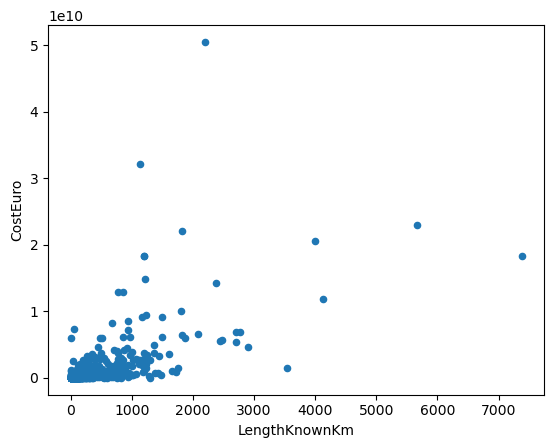

In [172]:
ax = pipes_df_orig.plot.scatter('LengthKnownKm','CostEuro')

## cost decision!

in the 2024 EGT report, I'm using the cost calculations from the most recent pipelines and terminals reports

pipelines here:  
https://docs.google.com/spreadsheets/d/1vb9-yPbfW7h8je6hxD0NdUaZb4jpIT4xOYpeCnhePs8/edit#gid=259015665

terminals here:  
https://docs.google.com/spreadsheets/d/1vdwrxwR0k8kwDrwneRsNchDNQ96U5D3cO8BLZaAb15o/edit#gid=462850940

In [173]:
mean_cost_per_km = 3.60726844 # million Euro per km

country_ratios_df_gas['TotalEstCostEuroMillionsHigh'] = numpy.nan

for idx,row in country_ratios_df_gas.iterrows():
    country_ratios_df_gas.loc[idx,'TotalEstCostEuroMillionsHigh'] = row['MergedKmByCountry'] * mean_cost_per_km

# now replace the ones that we have exact numbers for...
costs_exist_TF = ~country_ratios_df_gas['CostEuroPerKm'].isna()
country_ratios_df_gas.loc[costs_exist_TF,'TotalEstCostEuroMillionsHigh'] = \
    country_ratios_df_gas[costs_exist_TF]['CostEuroPerKm']/1e6 * \
    country_ratios_df_gas[costs_exist_TF]['MergedKmByCountry']

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_1906/4136194539.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_ratios_df_gas['TotalEstCostEuroMillionsHigh'] = numpy.nan


In [174]:
mean_cost_per_km =  3.60726844 # million Euro per km

country_ratios_df_gas['TotalEstCostEuroMillionsLow'] = numpy.nan

for idx,row in country_ratios_df_gas.iterrows():
    country_ratios_df_gas.loc[idx,'TotalEstCostEuroMillionsLow'] = row['MergedKmByCountry'] * mean_cost_per_km

# now replace the ones that we have exact numbers for...
costs_exist_TF = ~country_ratios_df_gas['CostEuro'].isna()

country_ratios_df_gas.loc[costs_exist_TF,'TotalEstCostEuroMillionsLow'] = \
    country_ratios_df_gas[costs_exist_TF]['CostEuroPerKm']/1e6 * \
    country_ratios_df_gas[costs_exist_TF]['MergedKmByCountry']
country_ratios_df_gas.loc[costs_exist_TF,'TotalEstCostEuroMillionsHigh'] = \
    country_ratios_df_gas[costs_exist_TF]['CostEuroPerKm']/1e6 * \
    country_ratios_df_gas[costs_exist_TF]['MergedKmByCountry']

country_ratios_df_gas.loc[(country_ratios_df_gas['PipelineName']=='Trans-Adriatic Gas Pipeline')&
                            (country_ratios_df_gas['SegmentName']=='TAP Expansion')&
                            (country_ratios_df_gas['Country']=='Italy'), ['TotalEstCostEuroMillionsLow','TotalEstCostEuroMillionsHigh']] = \
country_ratios_df.loc[(country_ratios_df.ProjectID=='P3203'),'CostEuro'].values[0]/1e6 * 2/3 * 0.5

country_ratios_df_gas.loc[(country_ratios_df_gas['PipelineName']=='Trans-Adriatic Gas Pipeline')&
                            (country_ratios_df_gas['SegmentName']=='TAP Expansion')&
                            (country_ratios_df_gas['Country']=='Greece'), ['TotalEstCostEuroMillionsLow','TotalEstCostEuroMillionsHigh']] = \
country_ratios_df.loc[(country_ratios_df.ProjectID=='P3203'),'CostEuro'].values[0]/1e6 * 2/3 * 0.5

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_1906/325386100.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_ratios_df_gas['TotalEstCostEuroMillionsLow'] = numpy.nan


In [175]:
country_ratios_df_gas['TotalEstCostEuroMillionsMean'] = \
    country_ratios_df_gas[['TotalEstCostEuroMillionsLow','TotalEstCostEuroMillionsHigh']].mean(axis=1)

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_1906/986689112.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_ratios_df_gas['TotalEstCostEuroMillionsMean'] = \


In [176]:
output_columns = ['Country',
                  'PipelineName',
                  'SegmentName',
                  'Status',
                  'CapacityBcm/y',
                  'MergedKmByCountry',
                  'TotalEstCostEuroMillionsMean',
                  'TotalEstCostEuroMillionsLow',
                  'TotalEstCostEuroMillionsHigh']
country_ratios_df_gas_excel = country_ratios_df_gas[country_ratios_df_gas['Status'].isin(['Proposed','Construction'])]
country_ratios_df_gas_excel = country_ratios_df_gas.sort_values(['Status',
                                                                     'PipelineName',
                                                                     'TotalEstCostEuroMillionsLow',
                                                                     'TotalEstCostEuroMillionsHigh'],
                                                                    ascending=[True,True,False,False])
country_ratios_df_gas_excel.replace(numpy.nan, '')
country_ratios_df_gas_excel = country_ratios_df_gas_excel[output_columns]

## print export, import, and within-EU pipelines

planned pipelines to import gas into the EU

In [244]:
# get the pipelines that import into the EU, export out, and are completely within
pipes_df_eu_imports = pipes_df_orig.copy()[(pipes_df_orig['Fuel']=='Gas')&
              (~pipes_df_orig['StartCountry'].isin(region_df_touse.Country))&
              (pipes_df_orig['EndCountry'].isin(region_df_touse.Country))]

pipes_df_eu_exports = pipes_df_orig.copy()[(pipes_df_orig['Fuel']=='Gas')&
              (pipes_df_orig['StartCountry'].isin(region_df_touse.Country))&
              (~pipes_df_orig['EndCountry'].isin(region_df_touse.Country))]

pipes_df_eu_within = pipes_df_orig.copy()[(pipes_df_orig['Fuel']=='Gas')&
              (pipes_df_orig['StartCountry'].isin(region_df_touse.Country))&
              (pipes_df_orig['EndCountry'].isin(region_df_touse.Country))]

## Table A2 all of Europe - import

In [273]:
import_projectids = country_ratios_df_gas.loc[
    (country_ratios_df_gas.Status.isin(['Proposed','Construction']))&
    (country_ratios_df_gas.Country.isin(region_df_touse.Country.tolist()))&
    ((~country_ratios_df_gas.StartCountry.isin(region_df_touse.Country.tolist()))&
    (country_ratios_df_gas.EndCountry.isin(region_df_touse.Country.tolist())))].ProjectID.tolist()

# all_other_projectids = list(set(country_ratios_df_gas.loc[
#     country_ratios_df_gas.Status.isin(['Proposed','Construction'])].ProjectID) - set(import_projectids))

all_other_projectids = country_ratios_df_gas.loc[
    (country_ratios_df_gas.Status.isin(['Proposed','Construction']))&
    (country_ratios_df_gas.Country.isin(region_df_touse.Country.tolist()))&
    (~country_ratios_df_gas.ProjectID.isin(import_projectids))].ProjectID.tolist()

country_ratios_df_gas_europe_only = country_ratios_df_gas.loc[
    (country_ratios_df_gas.Status.isin(['Proposed','Construction']))&
    (country_ratios_df_gas.Country.isin(region_df_touse.Country.tolist()))]

output_columns = ['Country',
                  'PipelineName',
                  'Status',
                  'CapacityBcm/y',
                  'MergedKmByCountry',
                  'TotalEstCostEuroMillionsMean',]
                  #'TotalEstCostEuroMillionsLow',
                  #'TotalEstCostEuroMillionsHigh']

country_ratios_df_gas_europe_only.loc[(country_ratios_df_gas_europe_only.ProjectID.isin(import_projectids))&
                            (country_ratios_df_gas_europe_only.Country.isin(region_df_touse.Country.tolist()))
                            ].sort_values(['Status','PipelineName','TotalEstCostEuroMillionsLow'], 
                                          ascending=[True,True,False])[output_columns].replace(numpy.nan,'').style.hide(axis='index')


Country,PipelineName,Status,CapacityBcm/y,MergedKmByCountry,TotalEstCostEuroMillionsMean
Ukraine,Taganrog-Melitopol-Berdyansk Gas Pipeline,Construction,,220.570000,795.655200
Türkiye,Arab Gas Pipeline,Proposed,,9.850000,35.531594
Spain,Nigeria-Morocco Gas Pipeline,Proposed,30.000000,137.850000,558.603754
Greece,Trans-Anatolian Gas Pipeline,Proposed,7.000000,0.000000,0.000000
Türkiye,Trans-Anatolian Gas Pipeline,Proposed,7.000000,0.000000,0.000000
Türkiye,Trans-Anatolian Gas Pipeline,Proposed,9.000000,0.000000,0.000000
Greece,Trans-Anatolian Gas Pipeline,Proposed,9.000000,0.000000,0.000000


In [272]:
import_projectids

['P0463', 'P3205', 'P3205', 'P3281', 'P3281', 'P3481', 'P5989']

## table A2 (Rob's summation)

## Table A3 (appendix)

### longer than 150 km

In [262]:
# must be longer than 150 total, and the segment must be located within the EU
projectids_threshold = list(
    set(country_ratios_df_gas.loc[(country_ratios_df_gas.MergedKmByPipeline>150)&
                                   (country_ratios_df_gas.ProjectID.isin(all_other_projectids))]['ProjectID'])
)

projectids_under_threshold = list(
    set(all_other_projectids) - set(projectids_threshold)
)

projectids_threshold.__len__()

29

In [263]:
projectids_under_threshold.__len__()

99

In [264]:
import_projectids.__len__()

7

In [265]:
all_other_projectids.__len__()

170

In [345]:
output_columns = ['Country',
                  'PipelineName',
                  #'Status',
                  'CapacityBcm/y',
                  'MergedKmByPipeline',
                  'MergedKmByCountry',
                  'TotalEstCostEuroMillionsMean']#,
                  #'TotalEstCostEuroMillionsLow',
                  #'TotalEstCostEuroMillionsHigh']

# country_ratios_df_gas.loc[
#     (country_ratios_df_gas.ProjectID.isin(import_projectids+all_other_projectids))&
#     (country_ratios_df_gas.Country.isin(region_df_touse.Country.tolist()))
#     ].groupby('Country')['MergedKmByCountry'].sum()

country_ratios_df_gas.replace(numpy.nan,'').loc[
    (country_ratios_df_gas.ProjectID.isin(import_projectids+all_other_projectids))&
    (country_ratios_df_gas.MergedKmByPipeline>150)&
    (country_ratios_df_gas.Country.isin(region_df_touse.Country.tolist()))
    ].sort_values([
    'Status','PipelineName','TotalEstCostEuroMillionsLow'], ascending=[True,True,False])[output_columns].style.hide(axis='index')


Country,PipelineName,CapacityBcm/y,MergedKmByPipeline,MergedKmByCountry,TotalEstCostEuroMillionsMean
Poland,Gustorzyn-Wronów Gas Pipeline,,308.000000,308.000000,1111.038680
Italy,Methanization of Sardinia Project,,573.000000,573.000000,600.000001
Poland,Pogórska-Wola-Tworzen Gas Pipeline,,168.000000,168.000000,300.500001
Ukraine,Taganrog-Melitopol-Berdyansk Gas Pipeline,,272.740000,220.570000,795.655200
Italy,Adriatica Pipeline,8.800000,170.000000,170.000000,553.600000
Albania,Albania–Kosovo Gas Pipeline,,212.000000,107.410000,108.929952
Serbia,Albania–Kosovo Gas Pipeline,,212.000000,104.590000,106.070047
Lithuania,Amber Grid Gas Transmission System,,286.820000,286.820000,1034.636734
Türkiye,Arab Gas Pipeline,,310.000000,9.850000,35.531594
Norway,Barents Sea Pipeline,,195.000000,195.000000,352.293577


### shorter than 150 km

In [343]:
# below_threshold_df = country_ratios_df_gas_europe_only.loc[(country_ratios_df_gas_europe_only.ProjectID.isin(projectids_under_threshold))&
#                                                  (country_ratios_df_gas_europe_only.Country.isin(region_df_touse.Country))]#.groupby('Status')

below_threshold_df = country_ratios_df_gas.loc[
    (country_ratios_df_gas.ProjectID.isin(import_projectids+all_other_projectids))&
    (country_ratios_df_gas.MergedKmByPipeline<=150)&
    (country_ratios_df_gas.Country.isin(region_df_touse.Country.tolist()))
    ]#.sort_values([
    #'Status','PipelineName','TotalEstCostEuroMillionsLow'], ascending=[True,True,False])[output_columns].style.hide(axis='index')

below_threshold_df.groupby('Status')[['MergedKmByCountry',
                                      'TotalEstCostEuroMillionsMean',
                                      'TotalEstCostEuroMillionsLow',
                                      'TotalEstCostEuroMillionsHigh']].sum()

,MergedKmByCountry,TotalEstCostEuroMillionsMean,TotalEstCostEuroMillionsLow,TotalEstCostEuroMillionsHigh
Status,,,,
Construction,608.62,1111.062977,1111.062977,1111.062977
Proposed,4867.56,11641.593289,11641.593289,11641.593289


# import terminals now

In [294]:
credentials_directory = '/Users/baird/Dropbox/_google-api/'
gc = pygsheets.authorize(service_account_env_var='GDRIVE_API_CREDENTIALS')
spreadsheet = gc.open_by_key('1tcS6Wd-Wp-LTDpLzFgJY_RSNDnbyubW3J_9HKIAys4A')
#spreadsheet = gc.open_by_key('1BHiidrJnzh96Em3KrqBpCoWaJ3GB5OeCY9dHVaEDEFs') # mar 22 2022 version for EGT
#spreadsheet = gc.open_by_key('1d0kLE0WmAn9b4XdugffiEaAHGWy6EhyF7zY1DM12zCc') # 1 Mar 2023 version for EGT report

#spreadsheet[1] "Gas Pipelines" tab is the second index
terms_df_orig = spreadsheet.worksheet('title', 'Terminals').get_as_df(start='A3')

In [295]:
# replace all -- with nans
terms_df_orig.replace('--', numpy.nan, inplace=True)
# only keep LNG terminals (remove oil)
terms_df_orig = terms_df_orig.loc[terms_df_orig.Fuel=='LNG']
# remove anything without a wiki page
terms_df_orig = terms_df_orig.loc[terms_df_orig.Wiki!='']
# remove N/A statuses
terms_df_orig = terms_df_orig.loc[terms_df_orig.Status!='']

In [296]:
terms_df_touse = terms_df_orig.loc[(terms_df_orig['Country'].isin(region_df_touse.Country.tolist()))&
                                   (terms_df_orig.Fuel=='LNG')]
terms_df_touse_imports = terms_df_touse.loc[(terms_df_orig['Country'].isin(region_df_touse['Country']))&
                                            (terms_df_touse['FacilityType']=='Import')]

In [297]:
terms_df_touse_imports.loc[terms_df_touse_imports.Status.isin(['Proposed','Construction'])].shape

(50, 98)

In [298]:
parent_metadata_df = spreadsheet.worksheet('title', 'Parent metadata (3/3)').get_as_df(start='A2')
parent_metadata_df.set_index('Parent', inplace=True)

## calculate floating costs (high and low estimates)

In [299]:
mean_cost_per_bcmy_floating = 1.653105e+08/1e6 # from 2023 terminals report # ols_estimator_f.coef_[0][0]/1e6
mean_cost_per_bcmy_onshore = 4.447106e+08/1e6 # from 2023 termnals report # ols_estimator_o.coef_[0][0]/1e6

terms_df_europe_import_future = terms_df_touse.loc[(terms_df_touse.Status.isin(['Proposed','Construction']))&
                                                 (terms_df_touse['FacilityType']=='Import')]

# do for floating
terms_df_europe_import_future['TotalEstCostEuroMillionsLow'] = numpy.nan

terms_df_europe_import_future.loc[(terms_df_europe_import_future['Floating']=='yes'),
                                'TotalEstCostEuroMillionsLow'] = \
terms_df_europe_import_future.loc[(terms_df_europe_import_future['Floating']=='yes'),
                                'CapacityInBcm/y'] * mean_cost_per_bcmy_floating

# now do for onshore
#terms_df_europe_import_future.loc[:,'TotalEstCostEuroMillionsLow'] = numpy.nan
terms_df_europe_import_future.loc[(terms_df_europe_import_future['Floating']==''),
                                'TotalEstCostEuroMillionsLow'] = \
terms_df_europe_import_future.loc[(terms_df_europe_import_future['Floating']==''),
                                'CapacityInBcm/y'] * mean_cost_per_bcmy_onshore

# then replace any that we have already
# now replace the ones that we have exact numbers for...
costs_exist_TF = ~terms_df_europe_import_future['CostEuro'].isna()
terms_df_europe_import_future.loc[costs_exist_TF,'TotalEstCostEuroMillionsLow'] = \
    terms_df_europe_import_future[costs_exist_TF]['CostEuro']/1e6 #*euro_multiplier/1e6

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_1906/740954265.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terms_df_europe_import_future['TotalEstCostEuroMillionsLow'] = numpy.nan


LARGER MEAN

In [300]:
mean_cost_per_bcmy_floating = 1.646520e+08/1e6 # from 2023 terminals report # terms_df_floating_toregress_dropdupes['CostEuroPerBcm/y'].mean()/1e6
mean_cost_per_bcmy_onshore = 4.447106e+08/1e6 # from 2023 termnals report # terms_df_onshore_toregress_dropdupes['CostEuroPerBcm/y'].mean()/1e6

# terms_df_europe_import_future = terms_df_touse.loc[(terms_df_touse.Status.isin(['Proposed','Construction']))&
#                                                  (terms_df_touse['FacilityType']=='Import')]

# do for floating
terms_df_europe_import_future['TotalEstCostEuroMillionsHigh'] = numpy.nan

terms_df_europe_import_future.loc[(terms_df_europe_import_future['Floating']=='yes'),
                                'TotalEstCostEuroMillionsHigh'] = \
terms_df_europe_import_future.loc[(terms_df_europe_import_future['Floating']=='yes'),
                                'CapacityInBcm/y'] * mean_cost_per_bcmy_floating

# now do for onshore
#terms_df_europe_import_future.loc[:,'TotalEstCostEuroMillionsLow'] = numpy.nan
terms_df_europe_import_future.loc[(terms_df_europe_import_future['Floating']==''),
                                'TotalEstCostEuroMillionsHigh'] = \
terms_df_europe_import_future.loc[(terms_df_europe_import_future['Floating']==''),
                                'CapacityInBcm/y'] * mean_cost_per_bcmy_onshore

# then replace any that we have already
# now replace the ones that we have exact numbers for...
costs_exist_TF = ~terms_df_europe_import_future['CostEuro'].isna()
terms_df_europe_import_future.loc[costs_exist_TF,'TotalEstCostEuroMillionsHigh'] = \
    terms_df_europe_import_future[costs_exist_TF]['CostEuro']/1e6 #*euro_multiplier/1e6

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_1906/563889206.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terms_df_europe_import_future['TotalEstCostEuroMillionsHigh'] = numpy.nan


In [301]:
terms_df_europe_import_future['TotalEstCostEuroMillionsMean'] = \
    terms_df_europe_import_future[['TotalEstCostEuroMillionsLow', 'TotalEstCostEuroMillionsHigh']].mean(axis=1)

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_1906/409365926.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  terms_df_europe_import_future['TotalEstCostEuroMillionsMean'] = \
/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_1906/409365926.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terms_df_europe_import_future['TotalEstCostEuroMillionsMean'] = \


### correct outliers/special cases

In [302]:
# Zeebrugge terminal is 116 million for BOTH expansion projects, so set one equal to zero so it's not counted twice
#T042601	https://www.gem.wiki/Fluxys_Zeebrugge_LNG_Terminal	Zeebrugge LNG Terminal, 2024 Expansion
#T042602	https://www.gem.wiki/Fluxys_Zeebrugge_LNG_Terminal	Zeebrugge LNG Terminal, 2026 Expansion
outliers_comboids = ['T042602']
terms_df_europe_import_future.loc[
    terms_df_europe_import_future.ComboID.isin(outliers_comboids),
    ['TotalEstCostEuroMillionsMean','TotalEstCostEuroMillionsLow','TotalEstCostEuroMillionsHigh']] = 0.0

## remove terminal expansions (costs aren't estimated for new builds)

# Table A1

In [303]:
terms_df_europe_import_future['CapacityInBcm/y'].sum()

248.7

In [346]:
output_columns = ['Country',
                  #'TerminalName',
                  'TerminalNameUnitName',
                  #'UnitName',
                  'CapacityInBcm/y',
                  #'Status',
                  #'FacilityType',
                  'TotalEstCostEuroMillionsMean']#,
                  #'TotalEstCostEuroMillionsLow',
                  #'TotalEstCostEuroMillionsHigh']

terms_df_europe_import_future['TerminalNameUnitName'] = (terms_df_europe_import_future.TerminalName + ' ' + terms_df_europe_import_future.UnitName).str.strip()
terms_df_europe_import_future.sort_values(['Status','TerminalNameUnitName'],
                                        ascending=[True,True])[output_columns].replace(numpy.nan,'').style.hide(axis='index')

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_1906/4201454884.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terms_df_europe_import_future['TerminalNameUnitName'] = (terms_df_europe_import_future.TerminalName + ' ' + terms_df_europe_import_future.UnitName).str.strip()


Country,TerminalNameUnitName,CapacityInBcm/y,TotalEstCostEuroMillionsMean
Greece,Alexandroupolis FSRU,5.500000,360.000000
Germany,Brunsbüttel LNG Terminal,8.000000,1300.000000
Cyprus,Cyprus LNG Terminal,2.720000,542.000000
Netherlands,Gate LNG Terminal Expansion,4.000000,350.000000
United Kingdom,Grain LNG Terminal Expansion,5.170000,200.000000
Estonia,Paldiski FSRU,,500.000000
Germany,Stade FSRU,6.000000,989.887500
Germany,Wilhelmshaven TES FSRU,5.000000,824.906250
Belgium,Zeebrugge LNG Terminal 2024 Expansion,6.390000,116.000000
Belgium,Zeebrugge LNG Terminal 2026 Expansion,1.770000,0.000000


# versus the LNG global report

In [347]:
terms_df_europe_import_future.TotalEstCostEuroMillionsMean.sum()

44434.40204138999

# table 2 - 2024 report

In [348]:
# table 1 shows country totals of pipeline length, cost, LNG capacity, cost, total cost
table2_columns = ['PipelineLengthKm','PipelineCostMillionEuro',
                  'LNGImportCapacityBcm/y','LNGTerminalCostMillionEuro','TotalCostMillionEuro']
table2_df = pandas.DataFrame(columns=table2_columns, index=region_df_touse.Country.tolist())

table2_df['PipelineLengthKm'] = country_ratios_df_gas.loc[
    (country_ratios_df_gas.ProjectID.isin(import_projectids+all_other_projectids))&
    (country_ratios_df_gas.Country.isin(region_df_touse.Country.tolist()))
    ].groupby('Country')['MergedKmByCountry'].sum()

table2_df['PipelineCostMillionEuro'] = country_ratios_df_gas.loc[
    (country_ratios_df_gas.ProjectID.isin(import_projectids+all_other_projectids))&
    (country_ratios_df_gas.Country.isin(region_df_touse.Country.tolist()))].groupby('Country')['TotalEstCostEuroMillionsMean'].sum()

# add half of Trans-Adriatic expansion to Italy, half to Greece
#table2_df.loc['Greece','PipelineCostMillionEuro']+=1035/2
#table2_df.loc['Italy','PipelineCostMillionEuro']+=1035/2

table2_df['LNGImportCapacityBcm/y'] = terms_df_europe_import_future.groupby('Country')['CapacityInBcm/y'].sum()
table2_df['LNGTerminalCostMillionEuro'] = terms_df_europe_import_future.groupby('Country')['TotalEstCostEuroMillionsMean'].sum()
table2_df['TotalCostMillionEuro'] = table2_df.loc[:,('PipelineCostMillionEuro','LNGTerminalCostMillionEuro')].sum(axis=1)

if 'Total' in table2_df.index:
    table2_df.drop(index='Total', inplace=True)   
    total = table2_df.sum(axis=0)
    total.name='Total'
    table2_df.loc['Total'] = total

else:
    total = table2_df.sum(axis=0)
    total.name='Total'
    table2_df.loc['Total'] = total

# replace NaN with ''
table2_df.replace(numpy.nan, '', inplace=True)
table2_df.replace(0.0, '', inplace=True)

In [349]:
table2_df#['LNGImportCapacityBcm/y'][:-1].replace('',numpy.nan).sum()

,PipelineLengthKm,PipelineCostMillionEuro,LNGImportCapacityBcm/y,LNGTerminalCostMillionEuro,TotalCostMillionEuro
Cyprus,921.15,2710.635336,2.72,542.0,3252.635336
Israel,246.0,706.812474,,,706.812474
Türkiye,156.13,268.60613,,,268.60613
Albania,325.55,323.264842,,,323.264842
Andorra,,,,,
Austria,59.39,214.235673,,,214.235673
Belgium,147.89,533.47893,8.16,116.0,649.47893
Bulgaria,546.57,1488.989092,,,1488.989092
Bosnia and Herzegovina,676.51,319.414059,,,319.414059
Belarus,,,,,


# creating figure 1 data

sum of Table 1 columns...

In [350]:
figure1_table_columns = ['TotalConstructionCostMillionEuro','TotalProposedCostMillionEuro','Total']
figure1_table_df = pandas.DataFrame(0, columns=figure1_table_columns, index=region_df_touse.Country,)


# for proposed
figure1_table_df['TotalProposedCostMillionEuro'] = \
country_ratios_df_gas.loc[country_ratios_df_gas.Status.isin(
    ['Proposed'])].groupby(['Country'])['TotalEstCostEuroMillionsMean'].sum()

figure1_table_df['TotalProposedCostMillionEuro'] = \
figure1_table_df['TotalProposedCostMillionEuro'].add( \
terms_df_europe_import_future.loc[terms_df_europe_import_future.Status.isin(
    ['Proposed'])].groupby(['Country'])['TotalEstCostEuroMillionsMean'].sum(), \
                                                    fill_value=0)

#figure1_table_df.loc['Italy','TotalProposedCostMillionEuro'] += 1035/2.
#figure1_table_df.loc['Greece','TotalProposedCostMillionEuro'] += 1035/2.

# for construction
figure1_table_df['TotalConstructionCostMillionEuro'] = \
country_ratios_df_gas.loc[country_ratios_df_gas.Status.isin(
    ['Construction'])].groupby(['Country'])['TotalEstCostEuroMillionsMean'].sum()

figure1_table_df['TotalConstructionCostMillionEuro'] = \
figure1_table_df['TotalConstructionCostMillionEuro'].add( \
terms_df_europe_import_future.loc[terms_df_europe_import_future.Status.isin(
    ['Construction'])].groupby(['Country'])['TotalEstCostEuroMillionsMean'].sum(), \
                                                         fill_value=0, axis=0)

figure1_table_df['Total'] = \
figure1_table_df[['TotalConstructionCostMillionEuro','TotalProposedCostMillionEuro']].sum(axis=1)
figure1_table_df.sort_values(['Total','Country'], ascending=[False, True], inplace=True)

figure1_table_df.replace(numpy.nan, '', inplace=True)
figure1_table_df.replace(0, '', inplace=True)

In [351]:
figure1_table_df

,TotalConstructionCostMillionEuro,TotalProposedCostMillionEuro,Total
Country,,,
Germany,3251.869951,16509.526906,19761.396857
Greece,788.079717,12467.404257,13255.483975
Italy,600.000001,10606.000078,11206.000078
United Kingdom,200.0,5023.289617,5223.289617
Poland,2372.43094,2191.257339,4563.688279
Cyprus,542.0,2710.635336,3252.635336
France,,2945.9083,2945.9083
Croatia,,2235.58963,2235.58963
Lithuania,,1971.225963,1971.225963


# owner analysis

## for pipelines

In [352]:
owner_parent_calculations_df = pandas.DataFrame()
# needs country, km in each country columns as well

for idx,row in country_ratios_df_gas.loc[
                            (country_ratios_df_gas.Status.isin(['Proposed','Construction']))&
                            (country_ratios_df_gas.Country.isin(region_df_touse.Country))].iterrows():
    
    parent_string = pipes_df_orig.loc[pipes_df_orig.ProjectID==row.ProjectID].Parent.values[0]
    #hq_country_string = pipes_df_orig.loc[pipes_df_orig.ProjectID==row.ProjectID].ParentHQCountry.values[0]
    
    #print(parent_string)
    #if parent_string == '--':
    #    parent_string = 'unknown [unknown %]'
    
    parent_list = re.sub(' \[.*?\]', '', parent_string).split('; ') # all entries must have an "Owner [%]" syntax, so [unknown %] is included
    percent_list = [float(i.rstrip('%'))/100. for i in re.findall('\\d+(?:\\.\\d+)?%', parent_string)]
    #print(percent_list)

    if parent_list.__len__()!=percent_list.__len__():
        if percent_list==[]:
            percent_list = [1/parent_list.__len__() for i in parent_list]
        else:
            nmissing = parent_list.__len__()-percent_list.__len__()
            # distribute nans evenly
            total = numpy.nansum(percent_list)
            leftover = 1-total
            percent_list += [leftover/nmissing]*nmissing

    # for when database isn't completely filled in for owners:
    for p_idx,parent in enumerate(parent_list):
        #if parent not in parents_df.index.to_list():
        #    parents_df.loc[parent,'ParentHQCountry']='unknown'
        owner_parent_calculations_df = pandas.concat([owner_parent_calculations_df, 
                                                      pandas.DataFrame([{'Parent':parent, 'ProjectID':row.ProjectID, 
                                                                         'FractionOwnership':percent_list[p_idx],
                                                                         'ParentHQCountry':parents_df.loc[parents_df.index==parent]['ParentHQCountry'].values[0],
                                                                         'PipelineCountry':row.Country,
                                                                         'Status':row.Status,
                                                                         'MergedKmByCountry':row.MergedKmByCountry,
                                                                         'MergedKmByPipeline':row.MergedKmByPipeline,
                                                                         'CapacityBOEd':row.CapacityBOEd,
                                                                         'TotalEstCostEuroMillionsMean':row.TotalEstCostEuroMillionsMean,
                                                                         'LengthPerCountryFraction':row.LengthPerCountryFraction}])])

owner_parent_calculations_df['KmOwnershipByCountry'] = owner_parent_calculations_df.FractionOwnership*owner_parent_calculations_df.MergedKmByCountry
owner_parent_calculations_df['EstimatedCostEuroMillionsMeanByCountry'] = \
        owner_parent_calculations_df.FractionOwnership*\
        owner_parent_calculations_df.TotalEstCostEuroMillionsMean
        # owner_parent_calculations_df.FractionOwnership*\
        # owner_parent_calculations_df.LengthPerCountryFraction*\
        # owner_parent_calculations_df.TotalEstCostEuroMillionsMean

In [353]:
pipeline_costs_df = owner_parent_calculations_df.groupby('Parent')[['EstimatedCostEuroMillionsMeanByCountry']].sum().sort_values(by='EstimatedCostEuroMillionsMeanByCountry', ascending=False)
pipeline_costs_df = pipeline_costs_df.rename(columns={'EstimatedCostEuroMillionsMeanByCountry':'Pipeline costs'})

## for terminals

In [354]:
# this cell takes the terminals data set (call it "terms_df_all", here we're using the indev terminals subset)
# and loops throw every row, breaks up the parent and % ownership strings,
# and outputs a dataframe owner_parent_calculations_df that has a bunch of different useful info related
# to parent shares, capacity, etc.
owner_parent_calculations_df = pandas.DataFrame() # empty df for storing owner/parent stuff

for idx,row in terms_df_europe_import_future.iterrows():
    parent_string = row.Parent #.values[0]
    if row.TerminalID=='T0292':
        print(parent_string)

    # the two lines below go through the parent entries in the sheet and split them,
    # recording the percents and parents in separate lists, to be dealt with later
    parent_list = re.sub(' \[.*?\]', '', parent_string).split('; ') # all entries must have an "Owner [%]" syntax, so [unknown %] is included
    percent_list = [float(i.rstrip('%'))/100. for i in re.findall('\\d+(?:\\.\\d+)?%', parent_string)]

    # if there are fewer recorded percents than number of parents
    if parent_list.__len__()!=percent_list.__len__():
        # if there are no percents, make them all equal
        
        if percent_list==[]:
            percent_list = [1/parent_list.__len__() for i in parent_list]
        # otherwise, get the difference and distribute the remainder equally among remaining parents
        else:
            #print(row.ComboID)
            nmissing = parent_list.__len__()-percent_list.__len__()
            # distribute nans evenly
            total = numpy.nansum(percent_list)
            leftover = 1-total
            percent_list += [leftover/nmissing]*nmissing
            #print(numpy.array(percent_list).sum())

    # now go through each parent and associated percent ownership
    # and store it alongside the project's name along with capacity, status, region, etc.
    # this is stored inside the big dataframe owner_parent_calculations_df
    for p_idx,parent in enumerate(parent_list):
        if row.TerminalID=='T0292':
            print(parent_list)
        # this if statement should not really be used
        if parent not in parent_metadata_df.index.to_list():
            print(parent, " doesn't exist as a parent")
            parent_metadata_df.loc[parent,'ParentHQCountry']='unknown'
        owner_parent_calculations_df = pandas.concat([owner_parent_calculations_df, 
                                                      pandas.DataFrame([{'Parent':parent, 'ComboID':row.ComboID,
                                                                         'TerminalID':row.TerminalID,
                                                                         'FractionOwnership':percent_list[p_idx],
                                                                         'PercentString':'{:.2f}%'.format(percent_list[p_idx]*100),
                                                                         'ParentHQCountry':parent_metadata_df.loc[parent_metadata_df.index==parent]['ParentHQCountry'].values[0],
                                                                         'ParentHQRegion':parent_metadata_df.loc[parent_metadata_df.index==parent]['ParentHQRegion'].values[0],
                                                                         'TerminalCountry':row.Country,
                                                                         'TerminalRegion':row.Region,
                                                                         'Status':row.Status,
                                                                         'FacilityType':row['FacilityType'],
                                                                         'CapacityInMtpa':row.CapacityInMtpa,
                                                                         'ProjectWiki':row.Wiki,
                                                                         'ProjectName':row.TerminalName+' '+str(row.UnitName),
                                                                         'TotalEstCostEuroMillionsMean':row.TotalEstCostEuroMillionsMean}])])

owner_parent_calculations_df.reset_index(drop=True, inplace=True)
owner_parent_calculations_df['CapacityOwnedInMtpa'] = owner_parent_calculations_df.FractionOwnership*owner_parent_calculations_df.CapacityInMtpa
owner_parent_calculations_df['ParentCapacityString'] = owner_parent_calculations_df.Parent + ' (' + owner_parent_calculations_df.CapacityOwnedInMtpa.round(1).astype(str).replace('nan','unknown') + ' mtpa)'
owner_parent_calculations_df['EstimatedCostEuroMillionsMeanByOwner'] = owner_parent_calculations_df.FractionOwnership*owner_parent_calculations_df.TotalEstCostEuroMillionsMean

In [355]:
terminal_costs_df = owner_parent_calculations_df.groupby('Parent')[['EstimatedCostEuroMillionsMeanByOwner']].sum().sort_values(by='EstimatedCostEuroMillionsMeanByOwner', ascending=False)
terminal_costs_df = terminal_costs_df.rename(columns={'EstimatedCostEuroMillionsMeanByOwner':'Terminal costs'})

In [356]:
pipeline_costs_df['Terminal costs'] = numpy.nan
terminal_costs_df['Pipeline costs'] = numpy.nan

## pipelines and terminals owners together

In [357]:
pipeline_and_terminal_costs_df = terminal_costs_df.add(pipeline_costs_df, fill_value=0)

In [358]:
pipeline_and_terminal_costs_df.replace(numpy.nan,0).sum().sum()

82028.9849927186

In [359]:
pipeline_and_terminal_costs_df['Total costs'] = pipeline_and_terminal_costs_df.sum(axis=1)
#pipeline_and_terminal_costs_df = pipeline_and_terminal_costs_df.loc[~pipeline_and_terminal_costs_df.index.isin(['unknown','other'])]

# Table A5

saved out as Excel and copied/pasted, also removed the bottom zero ones

In [360]:
pipeline_and_terminal_costs_df.sort_values('Total costs', ascending=False).replace(numpy.nan, '')

,Pipeline costs,Terminal costs,Total costs
Parent,,,
Snam,6186.389395,3584.381402,9770.770797
Tree Energy Solutions,,9169.18075,9169.180750
Electricite de France,4700.000002,,4700.000002
unknown,4307.731704,,4307.731704
Engie,,3220.87705,3220.877050
...,...,...,...
Ministry of Economy of Azerbaijan Republic,0.0,,0.000000
Excelerate Energy,,0.0,0.000000
Ministry of Infrastructure and Energy of Albania,,0.0,0.000000


In [361]:
pipeline_and_terminal_costs_df.sort_values('Total costs', ascending=False).replace(numpy.nan, '').to_excel('pipeline-and-terminal-owner-cost-rankings.xlsx')

In [362]:
pipeline_and_terminal_costs_df.sum(axis=0)

Pipeline costs    37594.582951
Terminal costs    44434.402041
Total costs       82028.984993
dtype: float64

# hydrogen exploring

In [283]:
pipes_df_touse = pipes_df_touse.loc[pipes_df_touse.H2Status!='']
pipes_df_touse_h2.H2Status.unique()

array(['Speculative (H2 only)', 'Pre-construction (H2 only)', 'Proposed',
       '', 'Shelved'], dtype=object)

In [284]:
pipes_df_touse_h2.loc[pipes_df_touse_h2.Fuel=='Hydrogen'][['ProjectID','Status','H2Status']]

,ProjectID,Status,H2Status
1276,P2477,Proposed,Proposed
3255,P4383,Proposed,
3256,P4387,Proposed,Proposed
3257,P4388,Proposed,Proposed
3258,P4389,Proposed,Proposed
...,...,...,...
3628,P5825,Proposed,
3629,P5826,Proposed,
3631,P5828,Proposed,
3654,P5851,Proposed,


In [285]:
print(pipes_df_touse_h2.loc[pipes_df_touse_h2.H2Status=='Pre-construction (H2 only)'].shape)
print(pipes_df_touse_h2.loc[pipes_df_touse_h2.H2Status=='Speculative (H2 only)'].shape)
print(pipes_df_touse_h2.loc[pipes_df_touse_h2.H2Status=='Proposed'].shape)

(16, 129)
(59, 129)
(141, 129)


In [286]:
pipes_df_touse_h2.groupby('H2Status')[['LengthMergedKm']].count()#.sum()

,LengthMergedKm
H2Status,
,4
Pre-construction (H2 only),16
Proposed,136
Shelved,4
Speculative (H2 only),47


In [287]:
country_ratios_df_gas.loc[(country_ratios_df_gas.H2Status!='')&
                            (country_ratios_df_gas.Country.isin(region_df_touse.Country))].groupby(['H2Status'])[['MergedKmByCountry']].sum()#.sort_values('MergedKmByCountry', ascending=False)




,MergedKmByCountry
H2Status,
Pre-construction (H2 only),1011.61
Proposed,19095.39
Speculative (H2 only),6805.68


In [288]:
country_ratios_df_gas.loc[(country_ratios_df_gas.H2Status!='')&
                            (country_ratios_df_gas.Country.isin(region_df_touse.Country))].groupby(['H2Type'])[['MergedKmByCountry']].sum()#.sort_values('MergedKmByCountry', ascending=False)


,MergedKmByCountry
H2Type,
new - 100%,280.00
new - blended,6696.11
new - unknown,1267.99
repurposed - blended,18668.58


In [289]:
country_ratios_df_gas.loc[(country_ratios_df_gas.H2Status!='')&
                            (country_ratios_df_gas.Country.isin(region_df_touse.Country))].groupby(['H2Status','H2Type'])[['MergedKmByCountry']].sum()#.sort_values('MergedKmByCountry', ascending=False)


MergedKmByCountry
H2Status                   H2Type                                 
Pre-construction (H2 only) repurposed - blended            1011.61
Proposed                   new - 100%                       280.00
                           new - blended                   3674.11
                           new - unknown                   1250.00
                           repurposed - blended           13891.28
Speculative (H2 only)      new - blended                   3022.00
                           new - unknown                     17.99
                           repurposed - blended            3765.69

In [290]:
country_ratios_df_gas.loc[(country_ratios_df_gas.H2Status!='')&
                            (country_ratios_df_gas.Country.isin(region_df_touse.Country))].groupby(['H2Status','H2Type'])[['MergedKmByCountry']].count()

MergedKmByCountry
H2Status                   H2Type                                 
Pre-construction (H2 only) repurposed - blended                  7
Proposed                   new - 100%                            3
                           new - blended                        49
                           new - unknown                         2
                           repurposed - blended                 99
Speculative (H2 only)      new - blended                         8
                           new - unknown                         2
                           repurposed - blended                 30

In [291]:
country_ratios_df_gas.loc[(country_ratios_df_gas.H2Status!='')&
                            (country_ratios_df_gas.Country.isin(region_df_touse.Country))].groupby(['H2Status','H2Type'])[['MergedKmByCountry']].count()

MergedKmByCountry
H2Status                   H2Type                                 
Pre-construction (H2 only) repurposed - blended                  7
Proposed                   new - 100%                            3
                           new - blended                        49
                           new - unknown                         2
                           repurposed - blended                 99
Speculative (H2 only)      new - blended                         8
                           new - unknown                         2
                           repurposed - blended                 30

In [292]:
2256.62+1998.36

4254.98

In [293]:
17054.74+476.25

17530.99

In [294]:
pipes_df_touse_h2.loc[pipes_df_touse_h2.H2Type.str.contains('blended')|
                      pipes_df_touse_h2.H2Type.str.contains('unknown')].shape

(203, 129)

In [295]:
pipes_df_touse_h2.loc[pipes_df_touse_h2.H2Type.str.contains('new')]['LengthMergedKm'].sum()

16898.15

In [296]:
pipes_df_touse_h2.loc[pipes_df_touse_h2.H2Type.str.contains('repurposed')]['LengthMergedKm'].sum()

21233.870000000003

In [297]:
178/195

0.9128205128205128

In [298]:
pipes_df_touse_h2.shape

(230, 129)

In [299]:
pipes_df_touse_h2.loc[pipes_df_touse_h2.H2Status=='Pre-construction (H2 only)']['LengthMergedKm'].sum()

2623.41

* how many H2 pipelines are planning to be 100%? blended?
  * A: really, none; the Malta-Italy Gas Pipeline is actually seeming realistic-ish but has language about "up to 100%" rather than a confirmation

## hydrogen table 1

In [300]:
country_ratios_df_gas.loc[country_ratios_df_gas.H2Status!=''].MergedKmByCountry.sort_values()

4077       0.00
1999       0.00
4074       0.00
4078       0.00
2000       0.00
         ...   
1038    1274.86
1534    2765.00
2646        NaN
5183        NaN
5589        NaN
Name: MergedKmByCountry, Length: 206, dtype: float64

In [301]:
# country_ratios_df_gas.loc[country_ratios_df_gas.H2Status!=''].groupby(
#     ['H2Status','Country'])[['MergedKmByCountry']].sum().sort_values('MergedKmByCountry', ascending=False)

country_ratios_df_gas.loc[country_ratios_df_gas.H2Status!=''].groupby(
    ['Country'])[['MergedKmByCountry']].sum().sort_values('MergedKmByCountry', ascending=False)

,MergedKmByCountry
Country,
Germany,3910.66
Bulgaria,3091.26
Italy,2685.88
Greece,2577.27
Spain,2012.82
Romania,1913.22
France,1430.82
Poland,1382.87
Hungary,1137.36


# visualize timeline

In [302]:
terms_df_touse_imports.loc[terms_df_touse_imports.Status.isin(['Operating'])]

,TerminalID,ProjectID,ComboID,Wiki,TerminalName,UnitName,FacilityType,FacilityType [ref],Status,Status [ref],Country,OtherLanguageName,Fuel,ImportExportOnly,Researcher,LastUpdated,ResearcherNotes,OtherEnglishNames,OtherEnglishNames [ref],Owner,Parent,ParentHQCountry,ChineseOwner(QCCOwner),ChineseOwner(QCCOwner) [ref],ProposalYear,ProposalMonth,Proposal [ref],ConstructionYear,ConstructionMonth,Construction [ref],StartYear1,StartMonth1,StartYear2,StartYear3,Start [ref],DelayedStartYear,Delayed,DelayType,Delay [ref],StartYearEarliest,ShelvedYear,Shelved [ref],CancelledYear,Cancelled [ref],StopYear,Stop [ref],ShelvedCancelledStatusType,Capacity,CapacityUnits,Capacity [ref],CapacityInMtpa,CapacityInBcm/y,Region,SubRegion,Location,Prefecture/District,State/Province,Latitude,Longitude,Accuracy,LocationNotes,Location [ref],Source,PowerPlantsSupplied,Cost,CostUnits,CostYear,Cost [ref],CostUSD,CostEuro,CostUSDPerMtpa,CostUSDPerBcm/y,CostEuroPerMtpa,CostEuroPerBcm/y,FIDStatus,FIDYear,FID [ref],ReExport,EuropeTracker,PCINumber,PCI3,PCI4,PCI5,PCI6,Offshore,Floating,FloatingVesselName,Opposition,ESJNotes,Defeated,LH2,NH3,LH2Notes,CCS,CCSNotes,EuroCrisisTracker,LinkedPipelineProjects,ImpactedByRussiaUkraineInvasion
8,T0541,0,T054100,https://www.gem.wiki/Etki_FSRU,Etki FSRU,,Import,,Operating,,Türkiye,,LNG,,AL,2023-07-17,,,,Kalyon Holding AS [unknown %]; Kolin Insaat [u...,Kalyon Holding AS [unknown %]; Kolin Holding A...,Türkiye; Türkiye,,,2016,,,2016,,,2016,12,,,,,,,,2016,,,,,,,,5.7,mtpa,,5.70,7.75,Asia,Western Asia,Izmir,Aliaga,Aegean,38.74443,26.895665,exact,,,,,,,,,NaN,NaN,NaN,NaN,NaN,NaN,FID,2016,,,yes,,,,,,yes,yes,Turquoise (previously Neptune),,,,,,,,,,,
34,T0500,0,T050000,https://www.gem.wiki/Sines_LNG_Terminal,Sines LNG Terminal,,Import,,Operating,,Portugal,,LNG,,RR,2023-09-16,,,,REN Atlantico [100.00%],REN Atlantico [100.00%],Portugal,,,,,,,,,2004,,,,,,,,,2004,,,,,,,,5.6,mtpa,,5.60,7.62,Europe,Southern Europe,Sines,Setúbal,Alentejo,37.9419,-8.8435,exact,,,,,,,,,NaN,NaN,NaN,NaN,NaN,NaN,,,,,yes,,,,,,,,,,,,,,,,,,,
36,T0532,0,T053200,https://www.gem.wiki/Huelva_LNG_Terminal,Huelva LNG Terminal,,Import,,Operating,,Spain,,LNG,,RR,2023-09-11,,,,Enagás [100.00%],Enagás [100.00%],Spain,,,,,,,,,1988,,,,,,,,,1988,,,,,,,,8.7,mtpa,,8.70,11.83,Europe,Southern Europe,Huelva,,Andalusia,37.17355,-6.911,exact,,,,,,,,,NaN,NaN,NaN,NaN,NaN,NaN,,,,,yes,,,,,,,,,,,,,,,,,,,
54,T0528,0,T052800,https://www.gem.wiki/El_Musel_LNG_Terminal,El Musel LNG Terminal,,Import,,Operating,,Spain,,LNG,,RR,2023-09-11,2013: terminal declared illegal for being too ...,Musel LNG Terminal,,Enagás [75.00%]; Reganosa [25.00%],Enagás [75.00%]; Reganosa Holdco [21.25%]; Soj...,Spain; Spain; Japan,,,2008,4,,2012,,,2023,8,,,,,yes,Confirmed,,2023,,,,,,,,8.0,bcm/y,,5.88,8.00,Europe,Southern Europe,Gijon,,Asturias,43.5696,-5.6934,exact,,,,,,,,,NaN,NaN,NaN,NaN,NaN,NaN,FID,,,,yes,,,,,,,,,yes,,,,,,,,yes,,
55,T0462,0,T046200,https://www.gem.wiki/Revithoussa_LNG_Terminal,Revithoussa LNG Terminal,,Import,,Operating,,Greece,,LNG,,RR,2023-09-14,Expanded in 2016: http://www.kslaw.com/imagese...,,,DESFA [100.00%],Copelouzos Group [unknown %]; Enagás [unknown ...,Greece; Spain; Belgium; Greece; Italy,,,,,,,,,2000,,,,,,,,,2000,,,,,,,,5.1,mtpa,,5.10,6.94,Europe,Southern Europe,Revithoussa Island,Megara Bay,Attica,37.96,23.4023,exact,,,,,,,,,NaN,NaN,NaN,NaN,NaN,NaN,,,,,yes,,,,,,,,,,,,,,,,,yes,,
95,T0524,0,T052400,https://www.gem.wiki/Bilbao_LNG_Terminal,Bilbao LNG Terminal,,Import,,Operating,,Spain,,LNG,,RR,2023-09-11,This says a 1.37 mtpa expansion was completed ...,Bahia de Bizkaia Gas Terminal,,Basque Energy Board (EVE) [50.00%]; Enagás [50...,Basque Energy Board (EVE) [50.00%]; Enagás [50...,Spain; Spain,,,,,,,,,2003,,,,,,,,,2003,,,,,,,,5.1,mtpa,,5.10,6.94,Europe,Southern Europe,Port of Bilbao,Zierbena,Biscay,43.3612,-3.09473,exact,,,,,,,,,NaN,NaN,NaN,NaN,NaN,NaN,,,,,yes,,,,,,,,,,,,,,,,,,,
188,T0522,0,T052200,https://www.gem.wiki/Barcelona_LNG_Terminal,Barcelona LNG Terminal,,Import,,Operating,

# IEEFA report

In [303]:
terms_df_orig.loc[(terms_df_orig.Region=='Europe')&
                  (terms_df_orig['FacilityType']=='Import')&
                  (terms_df_orig.Status=='Operating')]['CapacityInBcm/y'].sum()

270.53999999999996

In [304]:
terms_df_orig.loc[(terms_df_orig.Region=='Europe')&
                  (terms_df_orig['FacilityType']=='Import')&
                  (terms_df_orig.Status.isin(['Proposed','Construction']))]['CapacityInBcm/y'].sum()

245.98

In [305]:
terms_df_orig.loc[(terms_df_orig.EuroCrisisTracker=='yes')&
                  (terms_df_orig['FacilityType']=='Import')&
                  (terms_df_orig.Status.isin(['Proposed','Construction']))]['CapacityInBcm/y'].sum()

165.48

In [306]:
275.2+246.5

521.7

In [307]:
275.2+154.84

430.03999999999996

# CAN webinar matches?

In [308]:
terms_df_orig.loc[(terms_df_orig.EuroCrisisTracker=='yes')&
                  (terms_df_orig['FacilityType']=='Import')&
                  (terms_df_orig.Status.isin(['Proposed','Construction']))&
                  (terms_df_orig.StartYearEarliest.isin([2022,2023,2024]))]['CapacityInBcm/y'].sum()

59.18

In [309]:
terms_df_orig.loc[#(terms_df_orig.EuroCrisisTracker=='yes')&
                  (terms_df_orig.Country.isin(region_df_eu.Country))&
                  (terms_df_orig['FacilityType']=='Import')&
                  (terms_df_orig.Status.isin(['Proposed','Construction']))&
                  (terms_df_orig.StartYearEarliest.isin([2022,2023,2024]))]['CapacityInBcm/y'].sum()

89.19

In [310]:
terms_df_orig.loc[#(terms_df_orig.EuroCrisisTracker=='yes')&
                  (terms_df_orig.Country.isin(region_df_eu.Country))&
                  (terms_df_orig['FacilityType']=='Import')&
                  (terms_df_orig.Status.isin(['Proposed','Construction']))&
                  (~terms_df_orig.StartYearEarliest.isnull())]['CapacityInBcm/y'].sum()

203.1

In [311]:
terms_df_orig.loc[#(terms_df_orig.EuroCrisisTracker=='yes')&
                  (terms_df_orig.Country.isin(region_df_eu.Country))&
                  (terms_df_orig['FacilityType']=='Import')&
                  (terms_df_orig.Status.isin(['Proposed','Construction']))]['CapacityInBcm/y'].sum()

223.93

In [312]:
terms_df_orig.loc[#(terms_df_orig.EuroCrisisTracker=='yes')&
                  (terms_df_orig.Country.isin(region_df_eu.Country))&
                  (terms_df_orig['FacilityType']=='Import')&
                  (terms_df_orig.Status.isin(['Operating']))]['CapacityInBcm/y'].sum()

221.44